## A simple test to compare the refactor and previous version
### Started at 20201119, 14:35

In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv -g -b

CPython 3.8.5
IPython 7.17.0

numpy 1.19.1
openpiv 0.21.8b0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 76 Stepping 4, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 
Git branch :


### OpenPIV version used was 0.23.0, the openpiv folder was simply copy and pasted into the environment due to lack of internet at the time.

In [6]:
from openpiv import windef
import numpy as np
import os
import time
import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

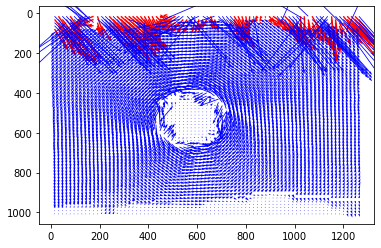

Image Pair 1
23.06215786933899  seconds


In [7]:
start = time.time()
settings = windef.Settings()

'Data related settings'
# Folder with the images to process
settings.filepath_images = './images/'
# Folder for the outputs
settings.save_path = './results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'results'
# Format and Image Sequence
settings.frame_pattern_a = 'A001_1.tif'
settings.frame_pattern_b = 'A001_2.tif'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'

'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.005
settings.dynamic_masking_filter_size = 7

settings.deformation_method = 'second image' # not present in previous version

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.iterations = 2  # select the number of PIV passes
# add the interroagtion window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes = (64, 32, 16) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = (32, 16, 8) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.MinMax_U_disp = (-50, 50)
settings.MinMax_V_disp = (-50, 50)
# The second filter is based on the global STD threshold
settings.std_threshold = 10  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 10  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
settings.do_sig2noise_validation = False # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
settings.sig2noise_threshold = 1.2
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=False #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method
'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings
windef.piv(settings)
end = time.time()
print(end-start, ' seconds')

In [1]:
from openpiv import tools
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def get_data(filename):
    data = np.loadtxt(filename)
    x = data[:,0]
    y = data[:,1]
    u = data[:,2]
    v = data[:,3]
    rows = np.unique(y).shape[0]
    cols = np.unique(x).shape[0]

    x = x.reshape(rows,cols)
    y = y.reshape(rows,cols)
    u = u.reshape(rows,cols)
    v = v.reshape(rows,cols)
    return(x,y,u,v)

In [3]:
dirA = './results/'

filename1 = dirA + 'previous_version.txt' 
filename2 = dirA + 'refactored_second_image_deformation.txt' 
filename3 = dirA + 'refactored_symmetric_deformation.txt'

In [4]:
x,y,u1,v1 = get_data(filename1)
x2,y2,u2,v2 = get_data(filename2)
x3,y3,u3,v3 = get_data(filename3)

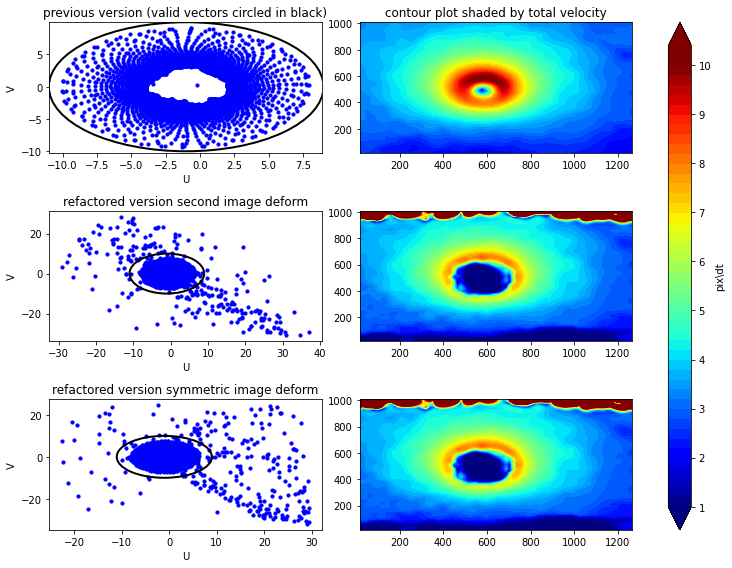

In [7]:
x,y,u,v = x,y,u1,v1

# Total velocity (speed)
TV = ( u**2 + v**2 )**0.5
    
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(11,8))
(ax1, ax2), (ax3,ax4), (ax5,ax6) = ax

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
# Plotting scatter of u/v components for a quick outlier inspection
ax1.scatter(u,v,s=10,c='blue')

valid = plt.Circle((-1, 0), 10, fill=False,lw=2)
ax1.add_artist(valid)

ax1.set_xlabel('U')
ax1.set_ylabel('V')
ax1.set_title('previous version (valid vectors circled in black)')

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
# background shading by total velocity
cs = ax2.contourf(x,y,TV,
                 np.arange(1, 10.5, 0.2),
                 extend='both',
                 cmap='jet',
                 vmin=1,
                 vmax=10
                    )
    
# Plotting vectors
ax2.set_title('contour plot shaded by total velocity')

# Collecting dimensions and components
x,y,u,v = x,y,u2,v2

# Total velocity (speed)
TV = ( u**2 + v**2 )**0.5

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
# Plotting scatter of u/v components for a quick outlier inspection
ax3.scatter(u,v,s=10,c='blue')

valid = plt.Circle((-1, 0), 10, fill=False,lw=2) # valid set to same as previous version
ax3.add_artist(valid)

ax3.set_xlabel('U')
ax3.set_ylabel('V')
ax3.set_title('refactored version second image deform')

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
# background shading by total velocity
CS = ax4.contourf(x,y,TV,
                 np.arange(1, 10.5, 0.2),
                 extend='both',
                 cmap='jet',
                 vmin=1,
                 vmax=10
                    )

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
# Collecting dimensions and components
x,y,u,v = x,y,u3,v3

# Plotting scatter of u/v components for a quick outlier inspection
ax5.scatter(u,v,s=10,c='blue')

valid = plt.Circle((-1, 0), 10, fill=False,lw=2) # valid set to same as previous version
ax5.add_artist(valid)

ax5.set_xlabel('U')
ax5.set_ylabel('V')
ax5.set_title('refactored version symmetric image deform')

'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''


# background shading by total velocity
CS = ax6.contourf(x,y,TV,
                 np.arange(1, 10.5, 0.2),
                 extend='both',
                 cmap='jet',
                 vmin=1,
                 vmax=10
                    )

plt.tight_layout()

# Colorbar
fig.colorbar(CS,
             ax=ax,
             orientation='vertical',
             label='pix\dt',
            ) 


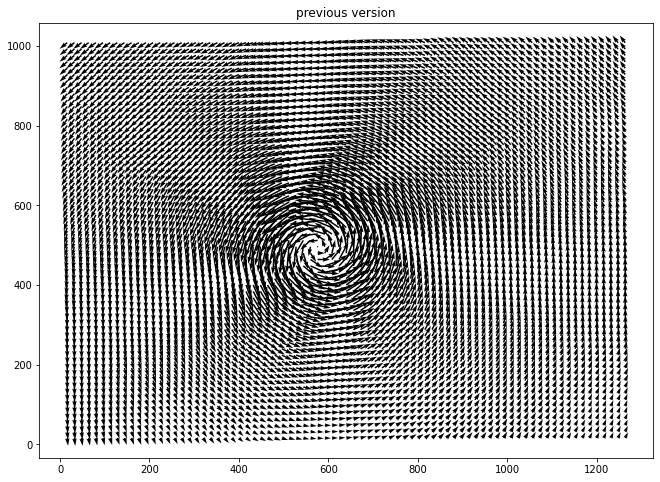

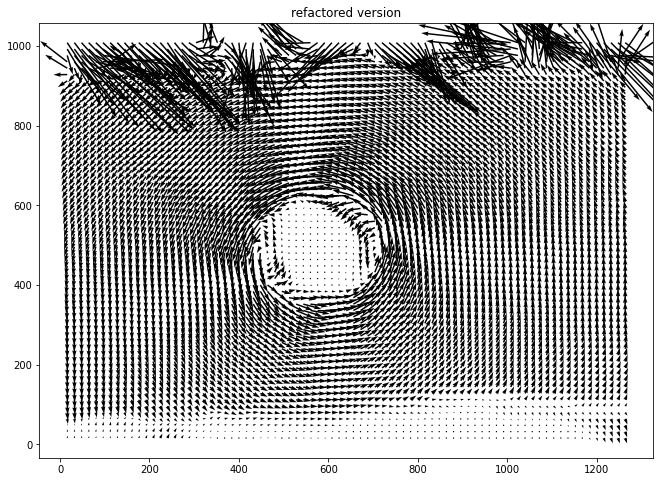

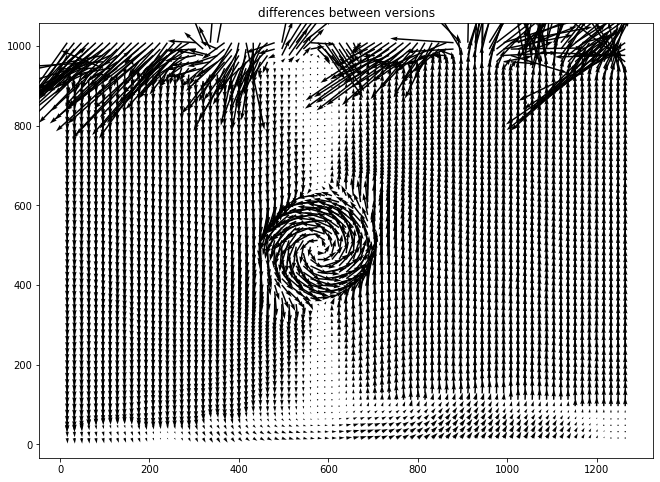

In [6]:
fig, ax = plt.subplots(figsize=(11,8))
x,y,u,v = x,y,u1,v1
plt.quiver(x,y,u,-v, scale = 200)
ax.set_title('previous version')


fig, ax = plt.subplots(figsize=(11,8))
x,y,u,v = x,y,u2,v2
plt.quiver(x,y,u,v, scale = 200)
ax.set_title('refactored version')

fig, ax = plt.subplots(figsize=(11,8))
ax.set_title('differences between versions')
x,y,u,v = x,y, u1 - u2, v1 - v2
v *= -1
plt.quiver(x,y,u,v, scale = 200)